In [1]:
!pyenv global 3.6
!eval "$(pyenv init --path)"
!python3 --version

Python 3.6.4


In [2]:
PYENV_VERSION=3.6
!python3 -m venv venv36

In [3]:
!python3 --version

Python 3.6.4


In [1]:
# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import sys
import os
from tqdm import tqdm  
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim import utils
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
import gensim.downloader as api

# import dlnlputils
# from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
#     vectorize_texts, SparseFeaturesDataset
# from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

# init_random_seed()

In [2]:
import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset

In [6]:
#подготовка признаков

In [3]:
import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w\d]+')


def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]


def character_tokenize(txt):
    return list(txt)


def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]


def add_fake_token(word2id, token=''):
    word2id_new = {token: i + 1 for token, i in word2id.items()}
    word2id_new[token] = 0
    return word2id_new


def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


PAD_TOKEN = '__PAD__'
NUMERIC_TOKEN = '__NUMBER__'
NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)


def replace_number_nokens(tokenized_texts):
    return [[token if not NUMERIC_RE.match(token) else NUMERIC_TOKEN for token in text]
            for text in tokenized_texts]

In [4]:
import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()


class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label

In [10]:
import pandas as pd
df = pd.read_csv("bitkogan.csv")

In [209]:
input_path = 'C:\\Users\\eduard\\jup\\project\\данные'

df = pd.DataFrame([])
for root, dirs, files in os.walk(input_path):
    for file in tqdm(files[:1]):
        df1 = pd.read_csv(f'данные\{file}')
        df = pd.concat([df, df1], axis=0, ignore_index=True)

df = df.sort_values('date', ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.81it/s]


In [211]:
pnl = pd.read_csv('данные/zBacktest_EURUSD_5_days.txt')
pnl['date_start'] = pd.to_datetime(pnl['date_start']).dt.strftime('%Y-%m-%d')
pnl['pnl_sign'] = pnl['pnl'].apply(lambda x: 1 if x >= 0 else 0)
pnl

date_start           pnl  pnl_sign
0   2022-03-02  -8967.190672         0
1   2022-03-03 -12548.743088         0
2   2022-03-04 -15486.634276         0
3   2022-03-09  12709.989084         1
4   2022-03-10   4612.031243         1
..         ...           ...       ...
91  2022-10-18   1318.776018         1
92  2022-10-19  -1381.633241         0
93  2022-10-20   -898.408314         0
94  2022-10-21    675.094148         1
95  2022-10-24   2042.855015         1

[96 rows x 3 columns]

In [70]:
pnl['pnl_sign'].sum() / pnl.shape[0]

0.4791666666666667

In [212]:
pnl['cumm_text'] = None
pnl

date_start           pnl  pnl_sign cumm_text
0   2022-03-02  -8967.190672         0      None
1   2022-03-03 -12548.743088         0      None
2   2022-03-04 -15486.634276         0      None
3   2022-03-09  12709.989084         1      None
4   2022-03-10   4612.031243         1      None
..         ...           ...       ...       ...
91  2022-10-18   1318.776018         1      None
92  2022-10-19  -1381.633241         0      None
93  2022-10-20   -898.408314         0      None
94  2022-10-21    675.094148         1      None
95  2022-10-24   2042.855015         1      None

[96 rows x 4 columns]

In [213]:
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

In [216]:
df_with_pnl = df[(df['date'] >= '2022-03-02') & (df['date'] <= '2022-11-01')]
df_with_pnl

id        date                                               text  \
71231  33230.0  2022-03-02  #AAPL \n⚡ Apple подтвердила приостановку прода...   
71232  33231.0  2022-03-02  #Макро \n📊 Рынок смартфонов в РФ по производит...   
71233  33232.0  2022-03-02  $=105,51р. RTS 0,00% BRENT +7,97%📌  LIVE Карта...   
71234  33233.0  2022-03-02  #Бонды \n🏦 Бельгийский депозитарий Euroclear, ...   
71235  33234.0  2022-03-02  #SBER \n🏦  Сбербанк повысил ставки по вкладам,...   
...        ...         ...                                                ...   
88251    911.0  2022-11-01  🇬🇧Основная проблема Великобритании сейчас поли...   
88252  42927.0  2022-11-01  🗓 Что было сегодня\n🖨 Энел Россия:  МСФО  9мес...   
88253  42928.0  2022-11-01  $=61,52р. RTS 0,00% BRENT +1,20%📌  LIVE Карта ...   
88254  12399.0  2022-11-01  Как прошел день🇷🇺 Российский рынок акций  (+0,...   
88255  15719.0  2022-11-01  РЫНОК ПРАЙСИТ +75 бп НА ЗАВТРАШНЕМ ЗАСЕДАНИИ F...   

      date_start  pnl Date data  
71231        NaN  NaN  NaN  NaN  
71232        NaN  NaN  NaN  NaN  
71233        NaN  NaN  NaN  NaN  
71234        NaN  NaN  NaN  NaN  
71235        NaN  NaN  NaN  NaN  
...          ...  ...  ...  ...  
88251        NaN  NaN  NaN  NaN  
88252        NaN  NaN  NaN  NaN  
88253        NaN  NaN  NaN  NaN  
88254        NaN  NaN  NaN  NaN  
88255        NaN  NaN  NaN  NaN  

[17025 rows x 7 columns]

In [185]:
i = 0
texts = ''
for _,row in tqdm(df_with_pnl.iterrows()):
    if i >= pnl.shape[0]:
        break

    if row['date'] <= pnl['date_start'][i]:
        texts += ' ' + row['text']
    else:
        pnl.at[i,'cumm_text'] = texts
        texts = ''
        i += 1
        continue

16401it [00:05, 2844.21it/s]


In [188]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(pnl)

In [189]:
train_tokenized = tokenize_corpus(train['cumm_text'])
val_tokenized = tokenize_corpus(val['cumm_text'])

In [190]:
print(' '.join(train_tokenized[0]))

фокус недели сегодня решение процентной ставке пресс конференция председателя банка россии саммит второй день военный комитет нато соберется сентября таллинне впервые участием швеции финляндии россети rsti воса присоединении компании rsti китай объем промышленного производства августе макро великобритания объем розничных продаж августе макро августе макро сентября price мсфо 6мес2022 fixp globaltrans мсфо 6мес2022 gltr сентября полюс мсфо 6мес2022 plzl запасы сырой нефти сентября polymetal мсфо 6мес2022 poly друзья всем привет сегодня самый день день четырех ведьм волнуйтесь никто собирается летать метлах хотя последнее время меня весьма стойкое ощущение этот день тянется достаточно долго собственно вами него вылезаем говорится ведьмы враждебные веют нами рынках подумали минутка лирики заканчивается хотя зрелище полетов метлах реальности очевидно выглядело скучно многое отдал чтобы посмотреть действо даже есть мысли кого известных персонажей хотелось узреть этом празднике жизни писали 

In [191]:
# строим словарь - vocabulary с помощью функции build_vocabulary
# принимает на вход список списков токенезированные
# word_doc_freq - содержит относительные частоты всех слов в датасете, он понадобиться 
# на этапе формирования матрицы признаков

MAX_DF = 0.8 #во скольких документах встречаеться слово
MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 12914
[('программы', 0), ('многих', 1), ('учетом', 2), ('обзоре', 3), ('валют', 4), ('долг', 5), ('минимум', 6), ('системы', 7), ('group', 8), ('итоге', 9)]


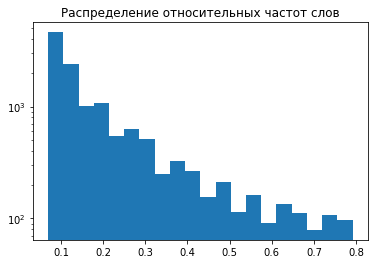

In [192]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [193]:
VECTORIZATION_MODE = 'tfidf'
# построение матрицы признаков по методу мешка слов
# функция vectorize_texts принимает на вход
#1. токенизированные список списков
#2. словарь
#3. вектор частоты токенизированны
#4. алгоритм взвешивания токенов по частоте mode - есть 4 алгорима - bin,tf,idf,tfidf
#5. флаг чтобы перемаштабировать флаг после взвешивания

train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()


Размерность матрицы признаков обучающей выборки (72, 12914)

Количество ненулевых элементов в обучающей выборке 183473
Процент заполненности матрицы признаков 19.73%



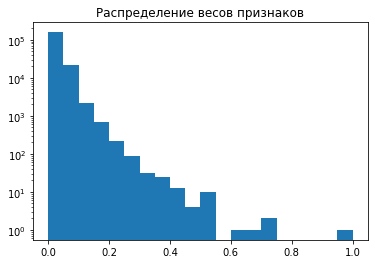

In [194]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [ ]:
#word2vec

In [160]:
from gensim.models import Word2Vec

In [ ]:
train_vectors

In [195]:
import gensim.downloader as api
for k, v in api.info().items():
    for k1, v1 in v.items():
        print(k1)

semeval-2016-2017-task3-subtaskBC
semeval-2016-2017-task3-subtaskA-unannotated
patent-2017
quora-duplicate-questions
wiki-english-20171001
text8
fake-news
20-newsgroups
__testing_matrix-synopsis
__testing_multipart-matrix-synopsis
fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [31]:
model_t1 = api.load('glove-twitter-200')

In [115]:
model_t = api.load('glove-twitter-100')

In [196]:
from gensim import utils

def get_vectors_gt100(row):
    '''
      word_doc_freq # частоты слов
      train_tokenized #сами слова
    '''
    vecs = [np.zeros(100)]
    for word in row:
        #print(row)
        try: 
            # если слово есть в нашем очищенном словаре
            # умножаем вектор на вес tfidf
            v = model_t[word] * word_doc_freq[vocabulary[word]] 
        except:
            v = np.zeros(100)
        vecs.append(v)
    return np.sum(np.array(vecs),axis=0)

In [197]:
train_vectors_gt100 = np.array([get_vectors_gt100(i) for i in train_tokenized])
val_vectors_gt100 = np.array([get_vectors_gt100(i) for i in val_tokenized])

In [198]:
train_vectors_gt100, train_vectors_gt100.shape

(array([[ 150.66733908, -216.38050509, -388.58968905, ..., -416.97839623,
           22.58570642,  106.82501764],
        [ 262.36012356, -312.05311468, -647.42407824, ..., -717.28529619,
           76.42729891,  119.96437437],
        [ 307.1395663 , -356.52293503, -759.25544124, ..., -764.03074176,
           66.19508727,  161.35999798],
        ...,
        [ 269.77502251, -302.06061828, -611.33688051, ..., -632.92173218,
           63.12735391,  144.27601078],
        [ 104.8664485 , -187.64701839, -383.8514571 , ..., -340.60297074,
           16.54751205,  117.60412281],
        [ 159.15491822, -194.24268732, -444.13106988, ..., -427.7019704 ,
           33.64345695,   63.06617649]]),
 (72, 100))

In [63]:
model_t1.most_similar(positive=['инвестор', 'рынок'], topn=1)

[('российский', 0.5974039435386658)]

In [199]:
model_t.most_similar(positive=['инвестор', 'рынок'], topn=1)

[('аналитик', 0.7176759839057922)]

In [200]:
y_train = train['pnl_sign']
X_train = train_vectors_gt100

y_val = val['pnl_sign']
X_val = val_vectors_gt100

In [201]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [202]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_val, y_val))
print('данные:', list(os.walk(input_path))[0][-1][:-2])

0.5833333333333334
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv', 'vts.csv', 'War_Wealth_Wisdom.csv']


In [177]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_val, y_val))
print('данные:', list(os.walk(input_path))[0][-1][:-2])

0.625
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv']


In [5]:
from gensim import utils

def get_vectors_gt100(row):
    '''
      word_doc_freq # частоты слов
      train_tokenized #сами слова
    '''
    vecs = [np.zeros(100)]
    for word in row:
        #print(row)
        try: 
            # если слово есть в нашем очищенном словаре
            # умножаем вектор на вес tfidf
            v = model_t[word] * word_doc_freq[vocabulary[word]] 
        except:
            v = np.zeros(100)
        vecs.append(v)
    return np.sum(np.array(vecs),axis=0)

In [6]:
model_t = api.load('glove-twitter-100')

In [8]:
input_path = 'C:\\Users\\eduard\\jup\\project\\данные' # нужно указать путь до папки с данными по новостям

for root, dirs, files in os.walk(input_path):
    for q in tqdm(range(1, 12)):
        df = pd.DataFrame([])
        for file in files[:q]:
            df1 = pd.read_csv(f'данные/{file}')
            df = pd.concat([df, df1], axis=0, ignore_index=True)

        df = df.sort_values('date', ignore_index=True)
        df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

        pnl = pd.read_csv('данные/zBacktest_EURUSD_5_days.txt')
        pnl['date_start'] = pd.to_datetime(pnl['date_start']).dt.strftime('%Y-%m-%d')
        pnl['pnl_sign'] = pnl['pnl'].apply(lambda x: 1 if x >= 0 else 0)
        pnl['cumm_text'] = None

        df_with_pnl = df[(df['date'] >= '2022-03-02') & (df['date'] <= '2022-11-01')]

        i = 0
        texts = ''
        for _,row in df_with_pnl.iterrows():
            if i >= pnl.shape[0]:
                break

            if row['date'] <= pnl['date_start'][i]:
                texts += ' ' + row['text']
            else:
                pnl.at[i,'cumm_text'] = texts
                texts = ''
                i += 1
                continue

        train, val = train_test_split(pnl)
        train_tokenized = tokenize_corpus(train['cumm_text'])
        val_tokenized = tokenize_corpus(val['cumm_text'])

        MAX_DF = 0.8 #во скольких документах встречаеться слово
        MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


        vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
        UNIQUE_WORDS_N = len(vocabulary)    
        VECTORIZATION_MODE = 'tfidf'
        train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

        train_vectors_gt100 = np.array([get_vectors_gt100(i) for i in train_tokenized])
        val_vectors_gt100 = np.array([get_vectors_gt100(i) for i in val_tokenized])

        model_t.most_similar(positive=['инвестор', 'рынок'], topn=1)

        y_train = train['pnl_sign']
        X_train = train_vectors_gt100

        y_val = val['pnl_sign']
        X_val = val_vectors_gt100

        model = LogisticRegression()
        model.fit(X_train, y_train)
        print(model.score(X_val, y_val))
        print('данные:', files[:q])
        print('всего наблюдений:', df_with_pnl.shape[0])


  9%|███████▌                                                                           | 1/11 [00:00<00:05,  1.86it/s]

0.4166666666666667
данные: ['Alfa_Wealth.csv']
всего наблюдений: 199


 18%|███████████████                                                                    | 2/11 [00:08<00:46,  5.15s/it]

0.375
данные: ['Alfa_Wealth.csv', 'bitkogan.csv']
всего наблюдений: 2315


 27%|██████████████████████▋                                                            | 3/11 [00:21<01:08,  8.52s/it]

0.5833333333333334
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv']
всего наблюдений: 4422


 36%|██████████████████████████████▏                                                    | 4/11 [00:32<01:05,  9.37s/it]

0.5
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv']
всего наблюдений: 4560


 45%|█████████████████████████████████████▋                                             | 5/11 [00:46<01:06, 11.12s/it]

0.7083333333333334
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv']
всего наблюдений: 6086


 55%|█████████████████████████████████████████████▎                                     | 6/11 [01:06<01:10, 14.05s/it]

0.375
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv']
всего наблюдений: 7436


 64%|████████████████████████████████████████████████████▊                              | 7/11 [01:29<01:08, 17.01s/it]

0.5416666666666666
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv']
всего наблюдений: 16313


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [01:50<00:55, 18.50s/it]

0.5416666666666666
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv']
всего наблюдений: 16421


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [02:16<00:41, 20.83s/it]

0.5416666666666666
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv']
всего наблюдений: 16573


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [02:37<00:20, 20.81s/it]

0.625
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv', 'vts.csv']
всего наблюдений: 16735


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [03:02<00:00, 16.60s/it]

0.5
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv', 'vts.csv', 'War_Wealth_Wisdom.csv']
всего наблюдений: 17025


In [221]:
input_path = 'C:\\Users\\eduard\\jup\\project\\данные'

for root, dirs, files in os.walk(input_path):
    for q in tqdm(range(1, 12)):
        df = pd.DataFrame([])
        for file in files[:q]:
            df1 = pd.read_csv(f'данные/{file}')
            df = pd.concat([df, df1], axis=0, ignore_index=True)

        df = df.sort_values('date', ignore_index=True)
        df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

        pnl = pd.read_csv('данные/zBacktest_EURUSD_5_days.txt')
        pnl['date_start'] = pd.to_datetime(pnl['date_start']).dt.strftime('%Y-%m-%d')
        pnl['pnl_sign'] = pnl['pnl'].apply(lambda x: 1 if x >= 0 else 0)
        pnl['cumm_text'] = None

        df_with_pnl = df[(df['date'] >= '2022-03-02') & (df['date'] <= '2022-11-01')]

        i = 0
        texts = ''
        for _,row in df_with_pnl.iterrows():
            if i >= pnl.shape[0]:
                break

            if row['date'] <= pnl['date_start'][i]:
                texts += ' ' + row['text']
            else:
                pnl.at[i,'cumm_text'] = texts
                texts = ''
                i += 1
                continue

        train, val = train_test_split(pnl)
        train_tokenized = tokenize_corpus(train['cumm_text'])
        val_tokenized = tokenize_corpus(val['cumm_text'])

        MAX_DF = 0.8 #во скольких документах встречаеться слово
        MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


        vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
        UNIQUE_WORDS_N = len(vocabulary)    
        VECTORIZATION_MODE = 'tfidf'
        train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

        train_vectors_gt100 = np.array([get_vectors_gt100(i) for i in train_tokenized])
        val_vectors_gt100 = np.array([get_vectors_gt100(i) for i in val_tokenized])

        model_t.most_similar(positive=['инвестор', 'рынок'], topn=1)

        y_train = train['pnl_sign']
        X_train = train_vectors_gt100

        y_val = val['pnl_sign']
        X_val = val_vectors_gt100

        model = LogisticRegression()
        model.fit(X_train, y_train)
        print(model.score(X_val, y_val))
        print('данные:', files[:q])
        print('всего наблюдений:', df_with_pnl.shape[0])


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]
191it [00:00, 11937.83it/s]
  9%|███████▌                                                                           | 1/11 [00:00<00:04,  2.18it/s]

0.5
данные: ['Alfa_Wealth.csv']
всего наблюдений: 199



0it [00:00, ?it/s]
632it [00:00, 5987.91it/s]
1231it [00:00, 3188.40it/s]
2236it [00:00, 4323.30it/s]
 18%|███████████████                                                                    | 2/11 [00:07<00:40,  4.48s/it]

0.4583333333333333
данные: ['Alfa_Wealth.csv', 'bitkogan.csv']
всего наблюдений: 2315



0it [00:00, ?it/s]
959it [00:00, 9377.83it/s]
1897it [00:00, 1782.37it/s]
2930it [00:01, 2918.35it/s]
4269it [00:01, 3297.71it/s]
 27%|██████████████████████▋                                                            | 3/11 [00:20<01:05,  8.21s/it]

0.6666666666666666
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv']
всего наблюдений: 4422



0it [00:00, ?it/s]
972it [00:00, 8579.93it/s]
1830it [00:00, 1676.71it/s]
2916it [00:01, 2912.69it/s]
4400it [00:01, 3184.65it/s]
 36%|██████████████████████████████▏                                                    | 4/11 [00:30<01:03,  9.03s/it]

0.5
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv']
всего наблюдений: 4560



0it [00:00, ?it/s]
1151it [00:00, 11470.25it/s]
2299it [00:01, 1538.69it/s] 
2828it [00:01, 1648.40it/s]
3824it [00:01, 2566.21it/s]
5867it [00:02, 2731.44it/s]
 45%|█████████████████████████████████████▋                                             | 5/11 [00:47<01:10, 11.69s/it]

0.5833333333333334
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv']
всего наблюдений: 6086



0it [00:00, ?it/s]
1356it [00:00, 12185.27it/s]
2575it [00:01, 1601.35it/s] 
3133it [00:02, 1106.82it/s]
4564it [00:02, 2041.17it/s]
5329it [00:02, 1861.09it/s]
7169it [00:03, 2250.97it/s]
 55%|█████████████████████████████████████████████▎                                     | 6/11 [01:06<01:11, 14.32s/it]

0.5
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv']
всего наблюдений: 7436



0it [00:00, ?it/s]
1663it [00:00, 15480.64it/s]
3212it [00:00, 14241.13it/s]
4640it [00:00, 4281.83it/s] 
5518it [00:01, 2487.09it/s]
6096it [00:02, 1729.79it/s]
6494it [00:02, 1363.60it/s]
6780it [00:03, 1136.98it/s]
6991it [00:03, 1015.62it/s]
8567it [00:03, 2251.52it/s]
10107it [00:03, 3640.45it/s]
10963it [00:04, 3282.07it/s]
11636it [00:04, 2520.90it/s]
12147it [00:05, 2476.21it/s]
15726it [00:05, 3007.77it/s]
 64%|████████████████████████████████████████████████████▊                              | 7/11 [01:27<01:06, 16.65s/it]

0.5
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv']
всего наблюдений: 16313



0it [00:00, ?it/s]
1633it [00:00, 14757.51it/s]
3109it [00:00, 14757.08it/s]
4585it [00:00, 4297.97it/s] 
5492it [00:01, 2416.05it/s]
6086it [00:02, 1736.87it/s]
6496it [00:02, 1400.62it/s]
6791it [00:03, 1136.62it/s]
7008it [00:03, 1014.15it/s]
8610it [00:03, 2244.08it/s]
10143it [00:04, 3593.16it/s]
10983it [00:04, 3131.67it/s]
11636it [00:04, 2471.01it/s]
12134it [00:05, 2328.67it/s]
13859it [00:05, 4005.80it/s]
15828it [00:05, 2943.18it/s]
 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [01:51<00:56, 18.69s/it]

0.25
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv']
всего наблюдений: 16421



0it [00:00, ?it/s]
1631it [00:00, 14807.93it/s]
3112it [00:00, 14767.56it/s]
4589it [00:00, 4478.83it/s] 
5501it [00:01, 2512.96it/s]
6100it [00:02, 1774.91it/s]
6514it [00:02, 1420.23it/s]
6812it [00:03, 1128.47it/s]
7030it [00:03, 992.39it/s] 
8333it [00:03, 1965.12it/s]
10091it [00:04, 3525.98it/s]
10921it [00:04, 3288.45it/s]
11581it [00:04, 2652.82it/s]
12089it [00:05, 2236.68it/s]
13644it [00:05, 3711.82it/s]
15960it [00:05, 2957.39it/s]
 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [02:17<00:42, 21.01s/it]

0.5416666666666666
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv']
всего наблюдений: 16573



0it [00:00, ?it/s]
1361it [00:00, 13475.87it/s]
2955it [00:00, 14769.42it/s]
4432it [00:00, 5058.65it/s] 
5364it [00:01, 2703.52it/s]
5978it [00:02, 1863.73it/s]
6402it [00:02, 1475.41it/s]
6707it [00:03, 1232.21it/s]
6934it [00:03, 1074.11it/s]
7108it [00:03, 943.99it/s] 
8294it [00:04, 1934.64it/s]
9850it [00:04, 3513.77it/s]
10614it [00:04, 3878.35it/s]
11312it [00:04, 3224.93it/s]
11864it [00:05, 2493.35it/s]
12292it [00:05, 2236.27it/s]
13924it [00:05, 4019.74it/s]
16119it [00:05, 2931.99it/s]
 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [02:42<00:22, 22.41s/it]

0.5416666666666666
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv', 'vts.csv']
всего наблюдений: 16735



0it [00:00, ?it/s]
1459it [00:00, 14013.61it/s]
3202it [00:00, 14733.86it/s]
4673it [00:00, 4330.11it/s] 
5575it [00:01, 2394.87it/s]
6165it [00:02, 1665.07it/s]
6570it [00:03, 1356.83it/s]
6861it [00:03, 1153.52it/s]
7077it [00:03, 1000.00it/s]
7242it [00:04, 880.68it/s] 
8054it [00:04, 1519.65it/s]
9809it [00:04, 3291.67it/s]
10638it [00:04, 3931.47it/s]
11379it [00:04, 3317.53it/s]
11966it [00:05, 2557.15it/s]
12420it [00:05, 2114.87it/s]
14102it [00:05, 3855.44it/s]
16401it [00:05, 2777.11it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [03:08<00:00, 17.11s/it]

0.4166666666666667
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv', 'vts.csv', 'War_Wealth_Wisdom.csv']
всего наблюдений: 17025


In [222]:
input_path = 'C:\\Users\\eduard\\jup\\project\\данные'

for root, dirs, files in os.walk(input_path):
    for q in tqdm(range(1, 12)):
        df = pd.DataFrame([])
        for file in files[:q]:
            df1 = pd.read_csv(f'данные/{file}')
            df = pd.concat([df, df1], axis=0, ignore_index=True)

        df = df.sort_values('date', ignore_index=True)
        df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

        pnl = pd.read_csv('данные/zBacktest_EURUSD_5_days.txt')
        pnl['date_start'] = pd.to_datetime(pnl['date_start']).dt.strftime('%Y-%m-%d')
        pnl['pnl_sign'] = pnl['pnl'].apply(lambda x: 1 if x >= 0 else 0)
        pnl['cumm_text'] = None

        df_with_pnl = df[(df['date'] >= '2022-03-02') & (df['date'] <= '2022-11-01')]

        i = 0
        texts = ''
        for _,row in tqdm(df_with_pnl.iterrows()):
            if i >= pnl.shape[0]:
                break

            if row['date'] <= pnl['date_start'][i]:
                texts += ' ' + row['text']
            else:
                pnl.at[i,'cumm_text'] = texts
                texts = ''
                i += 1
                continue

        train, val = train_test_split(pnl)
        train_tokenized = tokenize_corpus(train['cumm_text'])
        val_tokenized = tokenize_corpus(val['cumm_text'])

        MAX_DF = 0.8 #во скольких документах встречаеться слово
        MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


        vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
        UNIQUE_WORDS_N = len(vocabulary)    
        VECTORIZATION_MODE = 'tfidf'
        train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

        train_vectors_gt100 = np.array([get_vectors_gt100(i) for i in train_tokenized])
        val_vectors_gt100 = np.array([get_vectors_gt100(i) for i in val_tokenized])

        model_t.most_similar(positive=['инвестор', 'рынок'], topn=1)

        y_train = train['pnl_sign']
        X_train = train_vectors_gt100

        y_val = val['pnl_sign']
        X_val = val_vectors_gt100

        model = LogisticRegression()
        model.fit(X_train, y_train)
        print(model.score(X_val, y_val))
        print('данные:', files[:q])
        print('всего наблюдений:', df_with_pnl.shape[0])


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]
191it [00:00, 10402.43it/s]
  9%|███████▌                                                                           | 1/11 [00:00<00:05,  1.86it/s]

0.5
данные: ['Alfa_Wealth.csv']
всего наблюдений: 199



0it [00:00, ?it/s]
629it [00:00, 6080.93it/s]
1238it [00:00, 3290.57it/s]
2236it [00:00, 4307.34it/s]
 18%|███████████████                                                                    | 2/11 [00:07<00:36,  4.10s/it]

0.625
данные: ['Alfa_Wealth.csv', 'bitkogan.csv']
всего наблюдений: 2315



0it [00:00, ?it/s]
962it [00:00, 9053.32it/s]
1868it [00:00, 2301.28it/s]
2913it [00:00, 3683.99it/s]
4269it [00:01, 4095.89it/s]
 27%|██████████████████████▋                                                            | 3/11 [00:18<00:59,  7.44s/it]

0.625
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv']
всего наблюдений: 4422



0it [00:00, ?it/s]
961it [00:00, 9124.22it/s]
1874it [00:00, 2286.94it/s]
2976it [00:00, 3761.12it/s]
4400it [00:01, 4096.09it/s]
 36%|██████████████████████████████▏                                                    | 4/11 [00:29<01:02,  8.98s/it]

0.4166666666666667
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv']
всего наблюдений: 4560



0it [00:00, ?it/s]
1168it [00:00, 11393.09it/s]
2308it [00:01, 2018.71it/s] 
2852it [00:01, 2254.47it/s]
3886it [00:01, 3351.01it/s]
5867it [00:01, 3572.88it/s]
 45%|█████████████████████████████████████▋                                             | 5/11 [00:45<01:08, 11.44s/it]

0.5416666666666666
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv']
всего наблюдений: 6086



0it [00:00, ?it/s]
1386it [00:00, 12247.05it/s]
2611it [00:01, 2077.26it/s] 
3190it [00:01, 1594.82it/s]
4499it [00:01, 2700.18it/s]
5211it [00:02, 2588.55it/s]
7169it [00:02, 2979.89it/s]
 55%|█████████████████████████████████████████████▎                                     | 6/11 [01:04<01:10, 14.01s/it]

0.5
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv']
всего наблюдений: 7436



0it [00:00, ?it/s]
1504it [00:00, 14509.29it/s]
3064it [00:00, 14667.94it/s]
4531it [00:00, 5606.44it/s] 
5473it [00:01, 3205.39it/s]
6105it [00:01, 2242.74it/s]
6548it [00:02, 1841.83it/s]
6875it [00:02, 1576.66it/s]
7125it [00:02, 1649.52it/s]
8512it [00:02, 3139.53it/s]
10103it [00:02, 4926.01it/s]
10943it [00:03, 4416.43it/s]
11630it [00:03, 3417.59it/s]
12168it [00:03, 3376.16it/s]
13752it [00:03, 5301.77it/s]
15726it [00:03, 3943.92it/s]
 64%|████████████████████████████████████████████████████▊                              | 7/11 [01:24<01:03, 15.91s/it]

0.4583333333333333
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv']
всего наблюдений: 16313



0it [00:00, ?it/s]
1523it [00:00, 13591.97it/s]
3088it [00:00, 14477.28it/s]
4539it [00:00, 5521.89it/s] 
5469it [00:01, 3267.24it/s]
6096it [00:01, 2294.37it/s]
6537it [00:02, 1845.35it/s]
6861it [00:02, 1540.14it/s]
7106it [00:02, 1503.00it/s]
8546it [00:02, 2944.91it/s]
10093it [00:03, 4647.78it/s]
10941it [00:03, 4259.08it/s]
11635it [00:03, 3346.12it/s]
12178it [00:03, 3226.87it/s]
13701it [00:03, 4983.53it/s]
15828it [00:04, 3867.41it/s]
 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [01:46<00:53, 17.87s/it]

0.7083333333333334
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv']
всего наблюдений: 16421



0it [00:00, ?it/s]
1342it [00:00, 13134.70it/s]
2971it [00:00, 14367.62it/s]
4406it [00:00, 5671.23it/s] 
5333it [00:01, 3296.39it/s]
5959it [00:01, 2386.18it/s]
6403it [00:02, 1930.34it/s]
6731it [00:02, 1573.47it/s]
6978it [00:02, 1382.94it/s]
7497it [00:02, 1770.89it/s]
8928it [00:03, 3401.68it/s]
10249it [00:03, 4878.34it/s]
11067it [00:03, 4237.39it/s]
11731it [00:03, 3196.03it/s]
12249it [00:04, 3083.24it/s]
13743it [00:04, 4858.57it/s]
15960it [00:04, 3731.58it/s]
 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [02:11<00:40, 20.05s/it]

0.5416666666666666
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv']
всего наблюдений: 16573



0it [00:00, ?it/s]
1515it [00:00, 14522.98it/s]
3148it [00:00, 15082.02it/s]
4656it [00:00, 5207.23it/s] 
5607it [00:01, 3040.64it/s]
6241it [00:01, 2200.24it/s]
6686it [00:02, 1793.12it/s]
7013it [00:02, 1503.42it/s]
7259it [00:02, 1527.27it/s]
8647it [00:03, 2918.11it/s]
10159it [00:03, 4602.25it/s]
11017it [00:03, 4284.21it/s]
11723it [00:03, 3367.11it/s]
12275it [00:04, 2964.29it/s]
13761it [00:04, 4586.97it/s]
16119it [00:04, 3757.14it/s]
 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [02:34<00:20, 20.97s/it]

0.5416666666666666
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv', 'vts.csv']
всего наблюдений: 16735



0it [00:00, ?it/s]
1270it [00:00, 11457.90it/s]
2771it [00:00, 13277.52it/s]
4105it [00:00, 7098.52it/s] 
5035it [00:01, 3818.33it/s]
5672it [00:01, 2699.38it/s]
6129it [00:01, 2045.11it/s]
6465it [00:02, 1694.43it/s]
6721it [00:02, 1507.97it/s]
6926it [00:02, 1309.79it/s]
7090it [00:03, 1168.42it/s]
7226it [00:03, 1069.13it/s]
7777it [00:03, 1693.05it/s]
9219it [00:03, 3832.40it/s]
10531it [00:03, 5612.52it/s]
11344it [00:03, 4455.36it/s]
12000it [00:04, 3187.70it/s]
12510it [00:04, 2822.40it/s]
13847it [00:04, 4354.81it/s]
16401it [00:04, 3453.40it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:54<00:00, 15.83s/it]

0.5
данные: ['Alfa_Wealth.csv', 'bitkogan.csv', 'cbonds.csv', 'headlines_QUANTS.csv', 'mmi.csv', 'rshb_invest.csv', 'signal.csv', 'sky_bond.csv', 'themovchans.csv', 'vts.csv', 'War_Wealth_Wisdom.csv']
всего наблюдений: 17025
